In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import scipy
import seaborn as sns
import pysam
from IPython.core.display import Image
pd.set_option('display.max_columns', None)
%matplotlib inline

In [2]:
# Set up plotting settings
almost_black = '#262626'

plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.size'] = 14
plt.rcParams['font.weight'] = 'light'
plt.rcParams['text.color'] = almost_black

axisLineWidth = .5
plt.rcParams['axes.linewidth'] = axisLineWidth
plt.rcParams['lines.linewidth'] = 1.5

plt.rcParams['legend.frameon'] = False
plt.rcParams['legend.handletextpad'] = .25
plt.rcParams['legend.fontsize'] = 14

plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['ytick.color'] = almost_black
plt.rcParams['ytick.major.width'] = axisLineWidth
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['xtick.color'] = almost_black
plt.rcParams['xtick.major.width'] = axisLineWidth

def plotGrid(axis, vert_origin = True, horiz_origin=True, unity=True):
    ylim = axis.get_ylim()
    xlim = axis.get_xlim()
    if vert_origin:
        axis.plot((0,0), ylim, color='#BFBFBF', lw=.5, alpha=.5) 
    if horiz_origin:
        axis.plot(xlim,(0,0), color='#BFBFBF', lw=.5, alpha=.5) 
    if unity:
        xmin = min(xlim[0], ylim[0])
        xmax = max(xlim[1], ylim[1])
        axis.plot((xmin,xmax),(xmin,xmax), color='#BFBFBF', lw=.5, alpha=.5) 
        axis.plot((xmin,xmax),(-xmin,-xmax), color='#BFBFBF', lw=.5, alpha=.5) 

    axis.set_ylim(ylim)
    axis.set_xlim(xlim)

import warnings
warnings.filterwarnings('ignore')

# CRISPRn screen

In [3]:
# Loading the CRISPRn screen
# Processed by https://github.com/mhorlbeck/ScreenProcessing
# Load the gene-level phenotype score tables
gene_table_crisprn = pd.read_csv("crisprn_genetable.txt", header = [0,1, 2], sep='\t', index_col=0)
gene_table_crisprn_gamma_ave = gene_table_crisprn["gamma_20"]["ave_Rep1_Rep2"]

In [4]:
# Process the gene-level phenotype score tables
discScore = lambda z,p: p * np.abs(z)
table_dict = dict()
pseudo_dict = dict()
for i in ["Rep1", "Rep2", "ave_Rep1_Rep2"]:
    table = gene_table_crisprn["gamma_20"][i].copy().dropna()
    table["-log10 MW"] = -np.log10(table["Mann-Whitney p-value"])

    pseudo = table[table["transcripts"].str.contains('pseudo_transcript')]
    pseudoStd = np.std(pseudo["average phenotype of strongest 3"])

    table["discScore"] = discScore(table["average phenotype of strongest 3"]/pseudoStd,-1*np.log10(table["Mann-Whitney p-value"]))

    table["thres"] = table.loc[:,'discScore'] >= 5
    table = table[~table["transcripts"].str.contains('pseudo_transcript')]
    table['rank'] = table['discScore'].rank(ascending=False, method='dense')

    table = table[["transcripts", "Mann-Whitney p-value", "average phenotype of strongest 3", "discScore", "thres", "rank"]]

    table_dict[i] = table
    pseudo_dict[i] = pseudo[["transcripts", "Mann-Whitney p-value", "average phenotype of strongest 3"]]
gene_table_crisprn_gamma = pd.concat([table_dict["Rep1"], table_dict["Rep2"], table_dict["ave_Rep1_Rep2"]], axis=1, keys=["Rep1", "Rep2", "ave_Rep1_Rep2"])

gene_table_crisprn_gamma_pseudo = pd.concat([pseudo_dict["Rep1"], pseudo_dict["Rep2"], pseudo_dict["ave_Rep1_Rep2"]], axis=1, keys=["Rep1", "Rep2", "ave_Rep1_Rep2"])

In [5]:
# Load sgRNA counts table
sgRNA_counts_crisprn = pd.read_csv("crisprn_mergedcountstable.txt", sep='\t', header=[0,1], index_col=0)

Text(0.5,1,'CRISPRn')

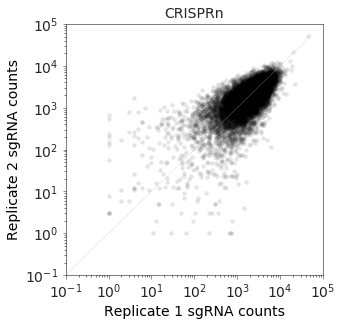

In [6]:
fig, ax = plt.subplots(1,1, figsize=(5, 4.5))
table = gene_table_crisprn.dropna()
rep1 = sgRNA_counts_crisprn["t2"]["Rep1"]
rep2 = sgRNA_counts_crisprn["t2"]["Rep2"]
ax.scatter(rep1, rep2, alpha=0.1, c = 'k', lw = 0, s = 20, label='gene', rasterized=True)

ax.set_ylabel('Replicate 2 sgRNA counts', fontsize=14)
ax.set_xlabel('Replicate 1 sgRNA counts', fontsize=14)

plt.tight_layout()
plotGrid(ax)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([0.1, 100000])
ax.set_ylim([0.1, 100000])
ax.set_title('CRISPRn', fontsize=14)

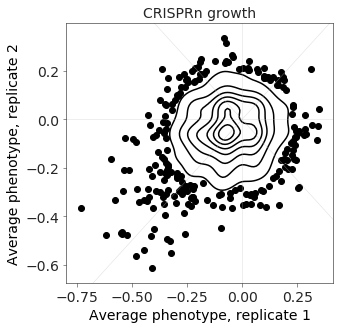

In [7]:
from scipy.stats import gaussian_kde

fig, ax = plt.subplots(1,1, figsize=(5, 4.8))

table = gene_table_crisprn["gamma_20"].dropna()
x = table["Rep1"]["average phenotype of strongest 3"]
y = table["Rep2"]["average phenotype of strongest 3"]

# Create a kernel density estimate (KDE)
xy = np.vstack([x, y])
kde = gaussian_kde(xy)

# Create grid for contour plot
x_grid = np.linspace(min(x), max(x), 100)
y_grid = np.linspace(min(y), max(y), 100)
X, Y = np.meshgrid(x_grid, y_grid)
Z = kde(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)

# Identify outliers (points with low density)
density = kde(xy)
threshold = np.percentile(density, 10)  # Define outliers as the lowest 10% density points
outliers = density < threshold

# Plot contour without fill
ax.contour(X, Y, Z, levels=10, colors='black')  # Only contour lines

# Overlay outliers as black dots
ax.scatter(x[outliers], y[outliers], color='black', label='Outliers')

ax.set_xlabel('Average phenotype, replicate 1', fontsize=14)
ax.set_ylabel('Average phenotype, replicate 2', fontsize=14)
ax.set_title('CRISPRn growth', fontsize = 14)

plotGrid(ax)
plt.tight_layout()

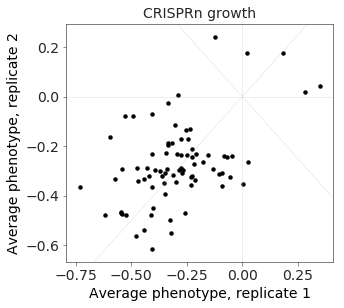

In [8]:
# Plot only the hits
fig, ax = plt.subplots(1,1, figsize=(5, 4.5))
table = gene_table_crisprn_gamma[gene_table_crisprn_gamma[[('Rep1', 'thres'), ('Rep2', 'thres'), ('ave_Rep1_Rep2', 'thres')]].any(axis=1)].dropna()
rep1 = table["Rep1"]["average phenotype of strongest 3"]
rep2 = table["Rep2"]["average phenotype of strongest 3"]
ax.scatter(rep1, rep2, alpha=1, c = 'k', lw = 0, s = 20, label='gene', rasterized=True)

ax.set_xlabel('Average phenotype, replicate 1', fontsize=14)
ax.set_ylabel('Average phenotype, replicate 2', fontsize=14)
ax.set_title('CRISPRn growth', fontsize = 14)

plt.tight_layout()
plotGrid(ax)

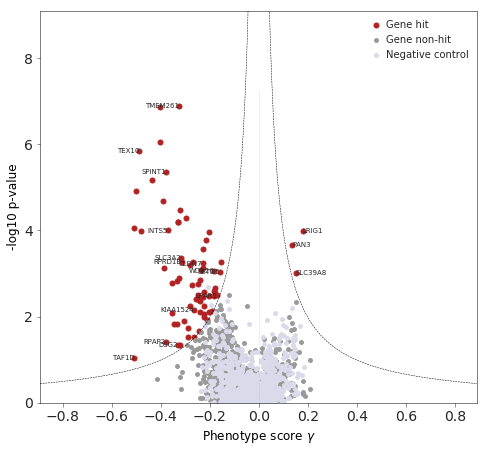

In [9]:
fig, axis = plt.subplots(1,1, figsize=(7, 6.5))

table = gene_table_crisprn_gamma["ave_Rep1_Rep2"].copy()
table["-log10 MW"] = -np.log10(table["Mann-Whitney p-value"])

pseudo = gene_table_crisprn_gamma_pseudo["ave_Rep1_Rep2"].copy()
pseudo["-log10 MW"] = -np.log10(pseudo["Mann-Whitney p-value"])
pseudoStd = np.std(pseudo["average phenotype of strongest 3"])

axis.scatter(table.loc[table['thres'],"average phenotype of strongest 3"], table.loc[table['thres'],"-log10 MW"],
                     s=25,
                     c='#b22222',
                     label = 'Gene hit')

axis.scatter(table.loc[table['thres'].ne(True),"average phenotype of strongest 3"], table.loc[table['thres'].ne(True),"-log10 MW"],
                     s=15,
                     c='#999999',
                     label = 'Gene non-hit')

axis.scatter(pseudo["average phenotype of strongest 3"],\
             pseudo["-log10 MW"], \
             c='#dadaeb', s = 15, label = 'Negative control')

for gene, row in table[table['thres']].iterrows():
    if gene in ["CDC151", "CLDN7", "KIAA1524", "TEX10", "RPRD1B", "LRIG1", "PAN3", "RPAP2", "SLC39A8", "SLC3A2", "INTS5", "DSG2", "LPAR5", "SETD5", "SPINT1", "TAF1D", "TMEM261", "WDR26"]:
        axis.text(row["average phenotype of strongest 3"], row["-log10 MW"], gene, fontsize=7, horizontalalignment = 'left' if row["average phenotype of strongest 3"] > 0 else 'right', verticalalignment='center')

plotGrid(axis, vert_origin=True, horiz_origin=False, unity=False)
ymax = np.ceil(max(table["-log10 MW"])) * 1.3
xmin = min(table["average phenotype of strongest 3"]) * 1.75
xmax = -xmin
axis.set_xlim((xmin,xmax))
axis.set_ylim((0,ymax))
axis.plot(np.linspace(xmin,xmax,1000),np.abs(5/np.linspace(xmin/pseudoStd,xmax/pseudoStd,1000)),'k--', lw=.5)
axis.set_ylabel('-log10 p-value', fontsize = 12)
axis.set_xlabel('Phenotype score $\gamma$', fontsize = 12)
axis.legend(loc='best', fontsize=10, handletextpad=0.005)

plt.tight_layout()

# CRISPRi/a

In [10]:
# Loading the CRISPRi and CRISPRa screens
# Processed by https://github.com/mhorlbeck/ScreenProcessing
# Load the gene-level phenotype score tables

gene_table_i = pd.read_csv("crispri_genetable.txt", header = [0,1, 2], sep='\t', index_col=0)
gene_table_a = pd.read_csv("crispra_genetable.txt", header = [0,1, 2], sep='\t', index_col=0)

In [11]:
gene_table_i_gamma_T2_ave = gene_table_i["gamma_T2"]["ave_Rep1_Rep2"]
gene_table_a_gamma_T2_ave = gene_table_a["gamma_T2"]["ave_Rep1_Rep2"]
gene_table_i_rho_T2_ave = gene_table_i["rho_T2"]["ave_Rep1_Rep2"]
gene_table_a_rho_T2_ave = gene_table_a["rho_T2"]["ave_Rep1_Rep2"]

In [12]:
# Process the gene-level phenotype score tables

discScore = lambda z,p: p * np.abs(z)

table_dict = dict()
pseudo_dict = dict()
for i in ["Rep1", "Rep2", "ave_Rep1_Rep2"]:
    table = gene_table_i["gamma_T2"][i].copy().dropna()
    table["-log10 MW"] = -np.log10(table["Mann-Whitney p-value"])

    pseudo = table[table["transcripts"].str.contains('pseudo_transcript')]
    pseudoStd = np.std(pseudo["average phenotype of strongest 3"])

    table["discScore"] = discScore(table["average phenotype of strongest 3"]/pseudoStd,-1*np.log10(table["Mann-Whitney p-value"]))

    table["thres"] = table.loc[:,'discScore'] >= 5
    table = table[~table["transcripts"].str.contains('pseudo_transcript')]
    table['rank'] = table['discScore'].rank(ascending=False, method='dense')

    table = table[["Mann-Whitney p-value", "average phenotype of strongest 3", "discScore", "thres", "rank"]]

    table_dict[i] = table
    pseudo_dict[i] = pseudo[["Mann-Whitney p-value", "average phenotype of strongest 3"]]
gene_table_i_gamma = pd.concat([table_dict["Rep1"], table_dict["Rep2"], table_dict["ave_Rep1_Rep2"]], axis=1, keys=["Rep1", "Rep2", "ave_Rep1_Rep2"])
gene_table_i_gamma_pseudo = pd.concat([pseudo_dict["Rep1"], pseudo_dict["Rep2"], pseudo_dict["ave_Rep1_Rep2"]], axis=1, keys=["Rep1", "Rep2", "ave_Rep1_Rep2"])


table_dict = dict()
pseudo_dict = dict()
for i in ["Rep1", "Rep2", "ave_Rep1_Rep2"]:
    table = gene_table_a["gamma_T2"][i].copy().dropna()
    table["-log10 MW"] = -np.log10(table["Mann-Whitney p-value"])

    pseudo = table[table["transcripts"].str.contains('pseudo_transcript')]
    pseudoStd = np.std(pseudo["average phenotype of strongest 3"])

    table["discScore"] = discScore(table["average phenotype of strongest 3"]/pseudoStd,-1*np.log10(table["Mann-Whitney p-value"]))

    table["thres"] = table.loc[:,'discScore'] >= 5
    table = table[~table["transcripts"].str.contains('pseudo_transcript')]
    table['rank'] = table['discScore'].rank(ascending=False, method='dense')

    table = table[["Mann-Whitney p-value", "average phenotype of strongest 3", "discScore", "thres", "rank"]]

    table_dict[i] = table
    pseudo_dict[i] = pseudo[["Mann-Whitney p-value", "average phenotype of strongest 3"]]
gene_table_a_gamma = pd.concat([table_dict["Rep1"], table_dict["Rep2"], table_dict["ave_Rep1_Rep2"]], axis=1, keys=["Rep1", "Rep2", "ave_Rep1_Rep2"])
gene_table_a_gamma_pseudo = pd.concat([pseudo_dict["Rep1"], pseudo_dict["Rep2"], pseudo_dict["ave_Rep1_Rep2"]], axis=1, keys=["Rep1", "Rep2", "ave_Rep1_Rep2"])


table_dict = dict()
pseudo_dict = dict()
for i in ["Rep1", "Rep2", "ave_Rep1_Rep2"]:
    table = gene_table_i["rho_T2"][i].copy().dropna()
    table["-log10 MW"] = -np.log10(table["Mann-Whitney p-value"])

    pseudo = table[table["transcripts"].str.contains('pseudo_transcript')]
    pseudoStd = np.std(pseudo["average phenotype of strongest 3"])

    table["discScore"] = discScore(table["average phenotype of strongest 3"]/pseudoStd,-1*np.log10(table["Mann-Whitney p-value"]))

    table["thres"] = table.loc[:,'discScore'] >= 5
    table = table[~table["transcripts"].str.contains('pseudo_transcript')]
    table['rank'] = table['discScore'].rank(ascending=False, method='dense')

    table = table[["Mann-Whitney p-value", "average phenotype of strongest 3", "discScore", "thres", "rank"]]

    table_dict[i] = table
    pseudo_dict[i] = pseudo[["Mann-Whitney p-value", "average phenotype of strongest 3"]]
gene_table_i_rho = pd.concat([table_dict["Rep1"], table_dict["Rep2"], table_dict["ave_Rep1_Rep2"]], axis=1, keys=["Rep1", "Rep2", "ave_Rep1_Rep2"])
gene_table_i_rho_pseudo = pd.concat([pseudo_dict["Rep1"], pseudo_dict["Rep2"], pseudo_dict["ave_Rep1_Rep2"]], axis=1, keys=["Rep1", "Rep2", "ave_Rep1_Rep2"])


table_dict = dict()
pseudo_dict = dict()
for i in ["Rep1", "Rep2", "ave_Rep1_Rep2"]:
    table = gene_table_a["rho_T2"][i].copy().dropna()
    table["-log10 MW"] = -np.log10(table["Mann-Whitney p-value"])

    pseudo = table[table["transcripts"].str.contains('pseudo_transcript')]
    pseudoStd = np.std(pseudo["average phenotype of strongest 3"])

    table["discScore"] = discScore(table["average phenotype of strongest 3"]/pseudoStd,-1*np.log10(table["Mann-Whitney p-value"]))

    table["thres"] = table.loc[:,'discScore'] >= 5
    table = table[~table["transcripts"].str.contains('pseudo_transcript')]
    table['rank'] = table['discScore'].rank(ascending=False, method='dense')

    table = table[["Mann-Whitney p-value", "average phenotype of strongest 3", "discScore", "thres", "rank"]]

    table_dict[i] = table
    pseudo_dict[i] = pseudo[["Mann-Whitney p-value", "average phenotype of strongest 3"]]
gene_table_a_rho = pd.concat([table_dict["Rep1"], table_dict["Rep2"], table_dict["ave_Rep1_Rep2"]], axis=1, keys=["Rep1", "Rep2", "ave_Rep1_Rep2"])
gene_table_a_rho_pseudo = pd.concat([pseudo_dict["Rep1"], pseudo_dict["Rep2"], pseudo_dict["ave_Rep1_Rep2"]], axis=1, keys=["Rep1", "Rep2", "ave_Rep1_Rep2"])

In [13]:
# Read in the sgRNA counts tables

In [14]:
sgRNA_counts_i = pd.read_csv("crispri_mergedcountstable.txt", header = [0,1], sep='\t', index_col=0)
sgRNA_counts_a = pd.read_csv("crispra_mergedcountstable.txt", header = [0,1], sep='\t', index_col=0)

Text(0.5,1,'CRISPRi growth')

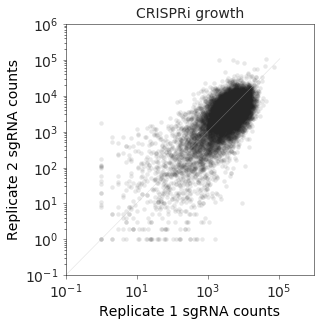

In [15]:
fig, ax = plt.subplots(1,1, figsize=(5, 4.5))
table = gene_table_crisprn.dropna()
rep1 = sgRNA_counts_i["T2"]["Rep1"]
rep2 = sgRNA_counts_i["T2"]["Rep2"]
# ax.tricontour(rep1, rep2, colors='k')
ax.scatter(rep1, rep2, alpha=0.1, c = almost_black, lw = 0, s = 20, label='gene', rasterized=True)

ax.set_ylabel('Replicate 2 sgRNA counts', fontsize = 14)
ax.set_xlabel('Replicate 1 sgRNA counts', fontsize = 14)

plt.tight_layout()
# ax.text(0, 0, 'R2 = ')
plotGrid(ax)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([0.1, 1000000])
ax.set_ylim([0.1, 1000000])
ax.set_title('CRISPRi growth', fontsize = 14)
# Image(saveFigures(fig,'output_old', 'CRISPRi_growth_sgRNA_correlation'))

Text(0.5,1,'CRISPRi drug')

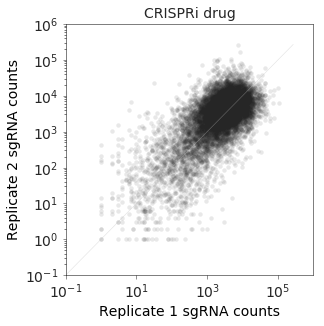

In [16]:
fig, ax = plt.subplots(1,1, figsize=(5, 4.5))
table = gene_table_crisprn.dropna()
rep1 = sgRNA_counts_i["T2_CIS"]["Rep1"]
rep2 = sgRNA_counts_i["T2_CIS"]["Rep2"]
# ax.tricontour(rep1, rep2, colors='k')
ax.scatter(rep1, rep2, alpha=0.1, c = almost_black, lw = 0, s = 20, label='gene', rasterized=True)

ax.set_ylabel('Replicate 2 sgRNA counts', fontsize = 14)
ax.set_xlabel('Replicate 1 sgRNA counts', fontsize = 14)

plt.tight_layout()
# ax.text(0, 0, 'R2 = ')
plotGrid(ax)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([0.1, 1000000])
ax.set_ylim([0.1, 1000000])
ax.set_title('CRISPRi drug', fontsize = 14)
# Image(saveFigures(fig,'output_old', 'CRISPRi_drug_sgRNA_correlation'))

Text(0.5,1,'CRISPRa growth')

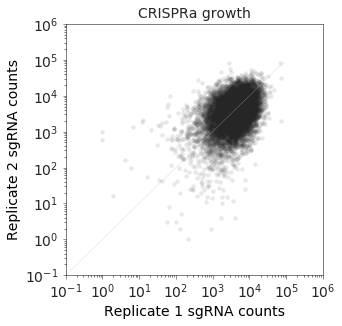

In [17]:
fig, ax = plt.subplots(1,1, figsize=(5, 4.5))
table = gene_table_crisprn.dropna()
rep1 = sgRNA_counts_a["T2"]["Rep1"]
rep2 = sgRNA_counts_a["T2"]["Rep2"]
# ax.tricontour(rep1, rep2, colors='k')
ax.scatter(rep1, rep2, alpha=0.1, c = almost_black, lw = 0, s = 20, label='gene', rasterized=True)

ax.set_ylabel('Replicate 2 sgRNA counts', fontsize = 14)
ax.set_xlabel('Replicate 1 sgRNA counts', fontsize = 14)

plt.tight_layout()
# ax.text(0, 0, 'R2 = ')
plotGrid(ax)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([0.1, 1000000])
ax.set_ylim([0.1, 1000000])
ax.set_title('CRISPRa growth', fontsize = 14)
# Image(saveFigures(fig,'output_old', 'CRISPRa_growth_sgRNA_correlation'))

Text(0.5,1,'CRISPRa drug')

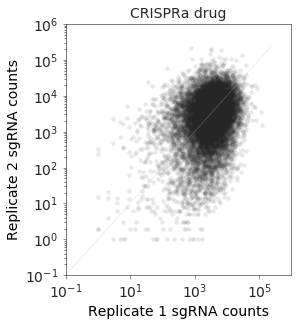

In [18]:
fig, ax = plt.subplots(1,1, figsize=(5, 4.5))
table = gene_table_crisprn.dropna()
rep1 = sgRNA_counts_a["T2_CIS"]["Rep1"]
rep2 = sgRNA_counts_a["T2_CIS"]["Rep2"]
# ax.tricontour(rep1, rep2, colors='k')
ax.scatter(rep1, rep2, alpha=0.1, c = almost_black, lw = 0, s = 20, label='gene', rasterized=True)

ax.set_ylabel('Replicate 2 sgRNA counts', fontsize = 14)
ax.set_xlabel('Replicate 1 sgRNA counts', fontsize = 14)

plt.tight_layout()
# ax.text(0, 0, 'R2 = ')
plotGrid(ax)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([0.1, 1000000])
ax.set_ylim([0.1, 1000000])
ax.set_title('CRISPRa drug', fontsize = 14)
# Image(saveFigures(fig,'output_old', 'CRISPRa_drug_sgRNA_correlation'))

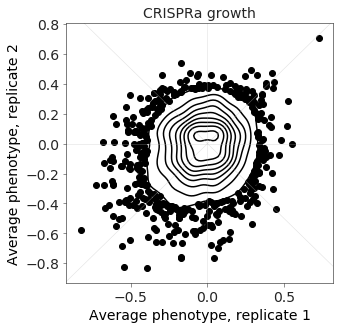

In [19]:
from scipy.stats import gaussian_kde

fig, ax = plt.subplots(1,1, figsize=(5, 4.8))

table = gene_table_a.dropna()
x = table["gamma_T2"]["Rep1"]["average phenotype of strongest 3"]
y = table["gamma_T2"]["Rep2"]["average phenotype of strongest 3"]

# Create a kernel density estimate (KDE)
xy = np.vstack([x, y])
kde = gaussian_kde(xy)

# Create grid for contour plot
x_grid = np.linspace(min(x), max(x), 100)
y_grid = np.linspace(min(y), max(y), 100)
X, Y = np.meshgrid(x_grid, y_grid)
Z = kde(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)

# Identify outliers (points with low density)
density = kde(xy)
threshold = np.percentile(density, 10)  # Define outliers as the lowest 10% density points
outliers = density < threshold

# Plot contour without fill
ax.contour(X, Y, Z, levels=10, colors='black')  # Only contour lines

# Overlay outliers as black dots
ax.scatter(x[outliers], y[outliers], color='black', label='Outliers')

ax.set_xlabel('Average phenotype, replicate 1', fontsize=14)
ax.set_ylabel('Average phenotype, replicate 2', fontsize=14)
ax.set_title('CRISPRa growth', fontsize = 14)

plotGrid(ax)
plt.tight_layout()

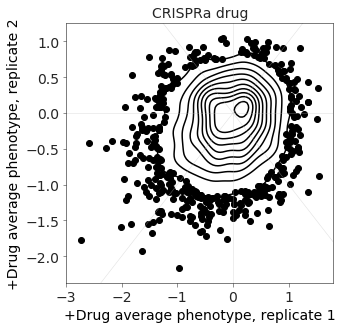

In [20]:
fig, ax = plt.subplots(1,1, figsize=(5, 4.8))

table = gene_table_a.dropna()
x = table["tau_T2"]["Rep1"]["average phenotype of strongest 3"]
y = table["tau_T2"]["Rep2"]["average phenotype of strongest 3"]

# Create a kernel density estimate (KDE)
xy = np.vstack([x, y])
kde = gaussian_kde(xy)

# Create grid for contour plot
x_grid = np.linspace(min(x), max(x), 100)
y_grid = np.linspace(min(y), max(y), 100)
X, Y = np.meshgrid(x_grid, y_grid)
Z = kde(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)

# Identify outliers (points with low density)
density = kde(xy)
threshold = np.percentile(density, 10)  # Define outliers as the lowest 10% density points
outliers = density < threshold

# Plot contour without fill
ax.contour(X, Y, Z, levels=10, colors='black')  # Only contour lines

# Overlay outliers as black dots
ax.scatter(x[outliers], y[outliers], color='black', label='Outliers')

ax.set_xlabel('+Drug average phenotype, replicate 1', fontsize=14)
ax.set_ylabel('+Drug average phenotype, replicate 2', fontsize=14)
ax.set_title('CRISPRa drug', fontsize = 14)

plotGrid(ax)
plt.tight_layout()

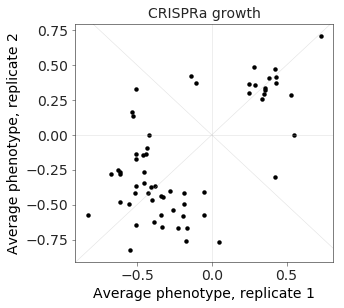

In [21]:
# Plot only the hits

fig, ax = plt.subplots(1,1, figsize=(5, 4.5))
table = gene_table_a_gamma[gene_table_a_gamma[[('Rep1', 'thres'), ('Rep2', 'thres'), ('ave_Rep1_Rep2', 'thres')]].any(axis=1)].dropna()
rep1 = table["Rep1"]["average phenotype of strongest 3"]
rep2 = table["Rep2"]["average phenotype of strongest 3"]
ax.scatter(rep1, rep2, alpha=1, c = 'k', lw = 0, s = 20, label='gene', rasterized=True)

ax.set_xlabel('Average phenotype, replicate 1', fontsize=14)
ax.set_ylabel('Average phenotype, replicate 2', fontsize=14)
ax.set_title('CRISPRa growth', fontsize = 14)

plt.tight_layout()
plotGrid(ax)

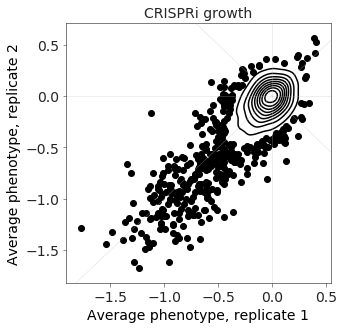

In [22]:
fig, ax = plt.subplots(1,1, figsize=(5, 4.8))

table = gene_table_i.dropna()
x = table["gamma_T2"]["Rep1"]["average phenotype of strongest 3"]
y = table["gamma_T2"]["Rep2"]["average phenotype of strongest 3"]

# Create a kernel density estimate (KDE)
xy = np.vstack([x, y])
kde = gaussian_kde(xy)

# Create grid for contour plot
x_grid = np.linspace(min(x), max(x), 100)
y_grid = np.linspace(min(y), max(y), 100)
X, Y = np.meshgrid(x_grid, y_grid)
Z = kde(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)

# Identify outliers (points with low density)
density = kde(xy)
threshold = np.percentile(density, 10)  # Define outliers as the lowest 10% density points
outliers = density < threshold

# Plot contour without fill
ax.contour(X, Y, Z, levels=10, colors='black')  # Only contour lines

# Overlay outliers as black dots
ax.scatter(x[outliers], y[outliers], color='black', label='Outliers')

ax.set_xlabel('Average phenotype, replicate 1', fontsize=14)
ax.set_ylabel('Average phenotype, replicate 2', fontsize=14)
ax.set_title('CRISPRi growth', fontsize = 14)

plotGrid(ax)
plt.tight_layout()

# Image(saveFigures(fig,'output_old', 'CRISPRi_growth_gene_correlation'))

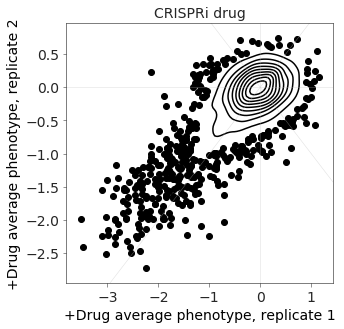

In [23]:
fig, ax = plt.subplots(1,1, figsize=(5, 4.8))

table = gene_table_i.dropna()
x = table["tau_T2"]["Rep1"]["average phenotype of strongest 3"]
y = table["tau_T2"]["Rep2"]["average phenotype of strongest 3"]

# Create a kernel density estimate (KDE)
xy = np.vstack([x, y])
kde = gaussian_kde(xy)

# Create grid for contour plot
x_grid = np.linspace(min(x), max(x), 100)
y_grid = np.linspace(min(y), max(y), 100)
X, Y = np.meshgrid(x_grid, y_grid)
Z = kde(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)

# Identify outliers (points with low density)
density = kde(xy)
threshold = np.percentile(density, 10)  # Define outliers as the lowest 10% density points
outliers = density < threshold

# Plot contour without fill
ax.contour(X, Y, Z, levels=10, colors='black')  # Only contour lines

# Overlay outliers as black dots
ax.scatter(x[outliers], y[outliers], color='black', label='Outliers')

ax.set_xlabel('+Drug average phenotype, replicate 1', fontsize=14)
ax.set_ylabel('+Drug average phenotype, replicate 2', fontsize=14)
ax.set_title('CRISPRi drug', fontsize = 14)

plotGrid(ax)
plt.tight_layout()

# Image(saveFigures(fig,'output_old', 'CRISPRi_drug_gene_correlation'))

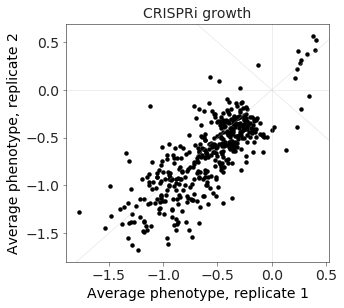

In [24]:
# Plot only the hits

fig, ax = plt.subplots(1,1, figsize=(5, 4.5))
table = gene_table_i_gamma[gene_table_i_gamma[[('Rep1', 'thres'), ('Rep2', 'thres'), ('ave_Rep1_Rep2', 'thres')]].any(axis=1)].dropna()
rep1 = table["Rep1"]["average phenotype of strongest 3"]
rep2 = table["Rep2"]["average phenotype of strongest 3"]
ax.scatter(rep1, rep2, alpha=1, c = 'k', lw = 0, s = 20, label='gene', rasterized=True)

ax.set_xlabel('Average phenotype, replicate 1', fontsize=14)
ax.set_ylabel('Average phenotype, replicate 2', fontsize=14)
ax.set_title('CRISPRi growth', fontsize = 14)

plt.tight_layout()
plotGrid(ax)

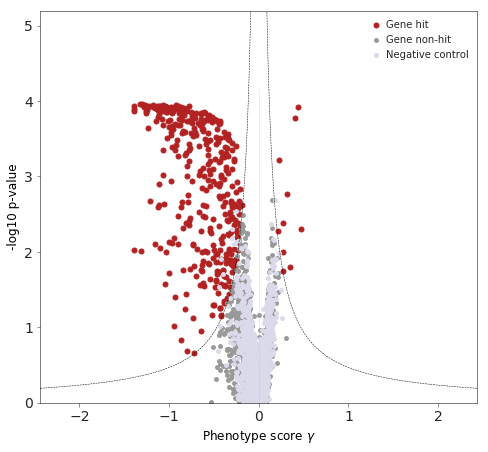

In [25]:
fig, axis = plt.subplots(1,1, figsize=(7, 6.5))

table = gene_table_i_gamma["ave_Rep1_Rep2"].copy()
table["-log10 MW"] = -np.log10(table["Mann-Whitney p-value"])

pseudo = gene_table_i_gamma_pseudo["ave_Rep1_Rep2"].copy()
pseudo["-log10 MW"] = -np.log10(pseudo["Mann-Whitney p-value"])
pseudoStd = np.std(pseudo["average phenotype of strongest 3"])

axis.scatter(table.loc[table['thres'],"average phenotype of strongest 3"], table.loc[table['thres'],"-log10 MW"],
                     s=25,
                     c='#b22222',
                     label = 'Gene hit')

axis.scatter(table.loc[table['thres'].ne(True),"average phenotype of strongest 3"], table.loc[table['thres'].ne(True),"-log10 MW"],
                     s=15,
                     c='#999999',
                     label = 'Gene non-hit')

axis.scatter(pseudo.loc[:, "average phenotype of strongest 3"],\
             pseudo.loc[:, "-log10 MW"], \
             c='#dadaeb', s = 15, label = 'Negative control')

plotGrid(axis, vert_origin=True, horiz_origin=False, unity=False)
ymax = np.ceil(max(table["-log10 MW"])) * 1.3
xmin = min(table["average phenotype of strongest 3"]) * 1.75
xmax = -xmin
axis.set_xlim((xmin,xmax))
axis.set_ylim((0,ymax))
axis.plot(np.linspace(xmin,xmax,1000),np.abs(5/np.linspace(xmin/pseudoStd,xmax/pseudoStd,1000)),'k--', lw=.5)
axis.set_ylabel('-log10 p-value', fontsize = 12)
axis.set_xlabel('Phenotype score $\gamma$', fontsize = 12)
axis.legend(loc='best', fontsize=10, handletextpad=0.005)

plt.tight_layout()


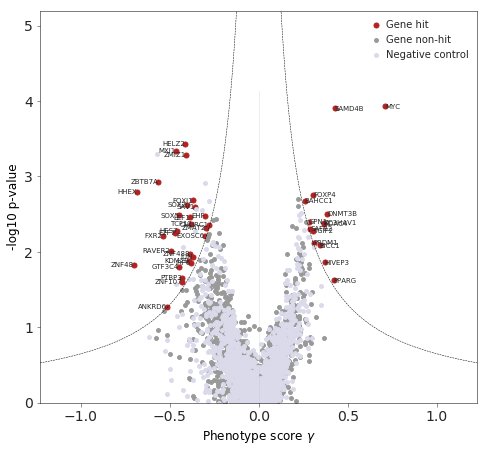

In [26]:
fig, axis = plt.subplots(1,1, figsize=(7, 6.5))

table = gene_table_a_gamma["ave_Rep1_Rep2"]
table["-log10 MW"] = -np.log10(table["Mann-Whitney p-value"])

pseudo = gene_table_a_gamma_pseudo["ave_Rep1_Rep2"]
pseudo["-log10 MW"] = -np.log10(pseudo["Mann-Whitney p-value"])
pseudoStd = np.std(pseudo["average phenotype of strongest 3"])

axis.scatter(table.loc[table['thres'],"average phenotype of strongest 3"], table.loc[table['thres'],"-log10 MW"],
                     s=25,
                     c='#b22222',
                     label = 'Gene hit')

axis.scatter(table.loc[table['thres'].ne(True),"average phenotype of strongest 3"], table.loc[table['thres'].ne(True),"-log10 MW"],
                     s=15,
                     c='#999999',
                     label = 'Gene non-hit')

axis.scatter(pseudo.loc[:, "average phenotype of strongest 3"],\
             pseudo.loc[:, "-log10 MW"], \
             c='#dadaeb', s = 15, label = 'Negative control')

for gene, row in table.query('thres').iterrows():
    axis.text(row["average phenotype of strongest 3"], row["-log10 MW"], gene, fontsize=7, horizontalalignment = 'left' if row["average phenotype of strongest 3"] > 0 else 'right', verticalalignment='center')

plotGrid(axis, vert_origin=True, horiz_origin=False, unity=False)
ymax = np.ceil(max(table["-log10 MW"])) * 1.3
xmin = min(table["average phenotype of strongest 3"]) * 1.75
xmax = -xmin
axis.set_xlim((xmin,xmax))
axis.set_ylim((0,ymax))
axis.plot(np.linspace(xmin,xmax,1000),np.abs(5/np.linspace(xmin/pseudoStd,xmax/pseudoStd,1000)),'k--', lw=.5)
axis.set_ylabel('-log10 p-value', fontsize = 12)
axis.set_xlabel('Phenotype score $\gamma$', fontsize = 12)
axis.legend(loc='best', fontsize=10, handletextpad=0.005)

plt.tight_layout()


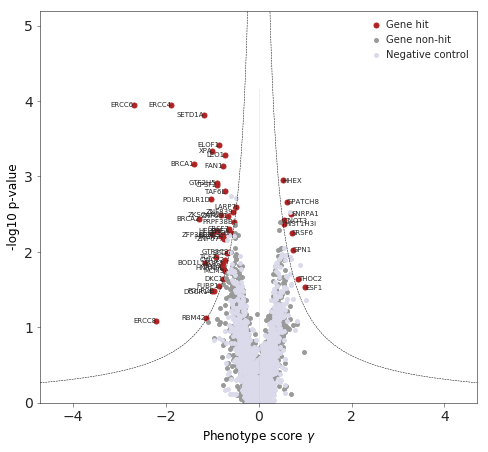

In [27]:
fig, axis = plt.subplots(1,1, figsize=(7, 6.5))

table = gene_table_i_rho["ave_Rep1_Rep2"]
table["-log10 MW"] = -np.log10(table["Mann-Whitney p-value"])

pseudo = gene_table_i_rho_pseudo["ave_Rep1_Rep2"]
pseudo["-log10 MW"] = -np.log10(pseudo["Mann-Whitney p-value"])
pseudoStd = np.std(pseudo["average phenotype of strongest 3"])

axis.scatter(table.loc[table['thres'],"average phenotype of strongest 3"], table.loc[table['thres'],"-log10 MW"],
                     s=25,
                     c='#b22222',
                     label = 'Gene hit')

axis.scatter(table.loc[table['thres'].ne(True),"average phenotype of strongest 3"], table.loc[table['thres'].ne(True),"-log10 MW"],
                     s=15,
                     c='#999999',
                     label = 'Gene non-hit')

axis.scatter(pseudo.loc[:, "average phenotype of strongest 3"],\
             pseudo.loc[:, "-log10 MW"], \
             c='#dadaeb', s = 15, label = 'Negative control')

for gene, row in table.query('thres').iterrows():
    axis.text(row["average phenotype of strongest 3"], row["-log10 MW"], gene, fontsize=7, horizontalalignment = 'left' if row["average phenotype of strongest 3"] > 0 else 'right', verticalalignment='center')

plotGrid(axis, vert_origin=True, horiz_origin=False, unity=False)
ymax = np.ceil(max(table["-log10 MW"])) * 1.3
xmin = min(table["average phenotype of strongest 3"]) * 1.75
xmax = -xmin
axis.set_xlim((xmin,xmax))
axis.set_ylim((0,ymax))
axis.plot(np.linspace(xmin,xmax,1000),np.abs(5/np.linspace(xmin/pseudoStd,xmax/pseudoStd,1000)),'k--', lw=.5)
axis.set_ylabel('-log10 p-value', fontsize = 12)
axis.set_xlabel('Phenotype score $\gamma$', fontsize = 12)
axis.legend(loc='best', fontsize=10, handletextpad=0.005)

plt.tight_layout()


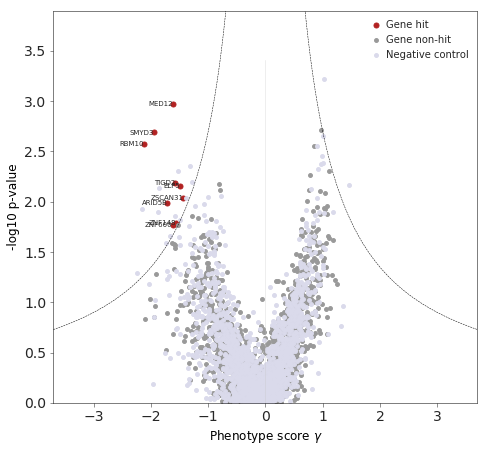

In [28]:
fig, axis = plt.subplots(1,1, figsize=(7, 6.5))

table = gene_table_a_rho["ave_Rep1_Rep2"]
table["-log10 MW"] = -np.log10(table["Mann-Whitney p-value"])

pseudo = gene_table_a_rho_pseudo["ave_Rep1_Rep2"]
pseudo["-log10 MW"] = -np.log10(pseudo["Mann-Whitney p-value"])
pseudoStd = np.std(pseudo["average phenotype of strongest 3"])

axis.scatter(table.loc[table['thres'],"average phenotype of strongest 3"], table.loc[table['thres'],"-log10 MW"],
                     s=25,
                     c='#b22222',
                     label = 'Gene hit')

axis.scatter(table.loc[table['thres'].ne(True),"average phenotype of strongest 3"], table.loc[table['thres'].ne(True),"-log10 MW"],
                     s=15,
                     c='#999999',
                     label = 'Gene non-hit')

axis.scatter(pseudo.loc[:, "average phenotype of strongest 3"],\
             pseudo.loc[:, "-log10 MW"], \
             c='#dadaeb', s = 15, label = 'Negative control')

for gene, row in table.query('thres').iterrows():
    axis.text(row["average phenotype of strongest 3"], row["-log10 MW"], gene, fontsize=7, horizontalalignment = 'left' if row["average phenotype of strongest 3"] > 0 else 'right', verticalalignment='center')

plotGrid(axis, vert_origin=True, horiz_origin=False, unity=False)
ymax = np.ceil(max(table["-log10 MW"])) * 1.3
xmin = min(table["average phenotype of strongest 3"]) * 1.75
xmax = -xmin
axis.set_xlim((xmin,xmax))
axis.set_ylim((0,ymax))
axis.plot(np.linspace(xmin,xmax,1000),np.abs(5/np.linspace(xmin/pseudoStd,xmax/pseudoStd,1000)),'k--', lw=.5)
axis.set_ylabel('-log10 p-value', fontsize = 12)
axis.set_xlabel('Phenotype score $\gamma$', fontsize = 12)
axis.legend(loc='best', fontsize=10, handletextpad=0.005)

plt.tight_layout()


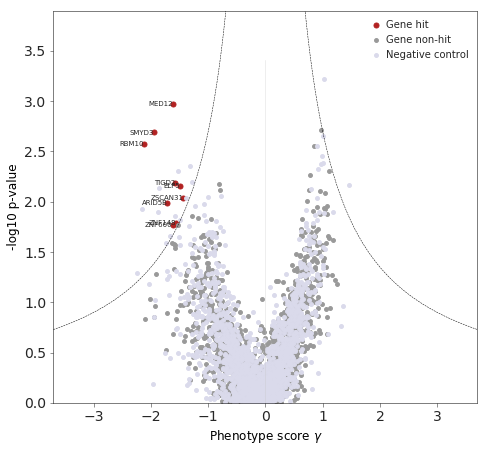

In [29]:
fig, axis = plt.subplots(1,1, figsize=(7, 6.5))

axis.scatter(table.loc[table['thres'],"average phenotype of strongest 3"], table.loc[table['thres'],"-log10 MW"],
                     s=25,
                     c='#b22222',
                     label = 'Gene hit')

axis.scatter(table.loc[table['thres'].ne(True),"average phenotype of strongest 3"], table.loc[table['thres'].ne(True),"-log10 MW"],
                     s=15,
                     c='#999999',
                     label = 'Gene non-hit')

axis.scatter(pseudo.loc[:, "average phenotype of strongest 3"],\
             pseudo.loc[:, "-log10 MW"], \
             c='#dadaeb', s = 15, label = 'Negative control')

for gene, row in table.query('thres').iterrows():
    axis.text(row["average phenotype of strongest 3"], row["-log10 MW"], gene, fontsize=7, horizontalalignment = 'left' if row["average phenotype of strongest 3"] > 0 else 'right', verticalalignment='center')

plotGrid(axis, vert_origin=True, horiz_origin=False, unity=False)
ymax = np.ceil(max(table["-log10 MW"])) * 1.3
xmin = min(table["average phenotype of strongest 3"]) * 1.75
xmax = -xmin
axis.set_xlim((xmin,xmax))
axis.set_ylim((0,ymax))
axis.plot(np.linspace(xmin,xmax,1000),np.abs(5/np.linspace(xmin/pseudoStd,xmax/pseudoStd,1000)),'k--', lw=.5)
axis.set_ylabel('-log10 p-value', fontsize = 12)
axis.set_xlabel('Phenotype score $\gamma$', fontsize = 12)
axis.legend(loc='best', fontsize=10, handletextpad=0.005)

plt.tight_layout()

In [30]:
# Compare CRISPRi and CRISPRa

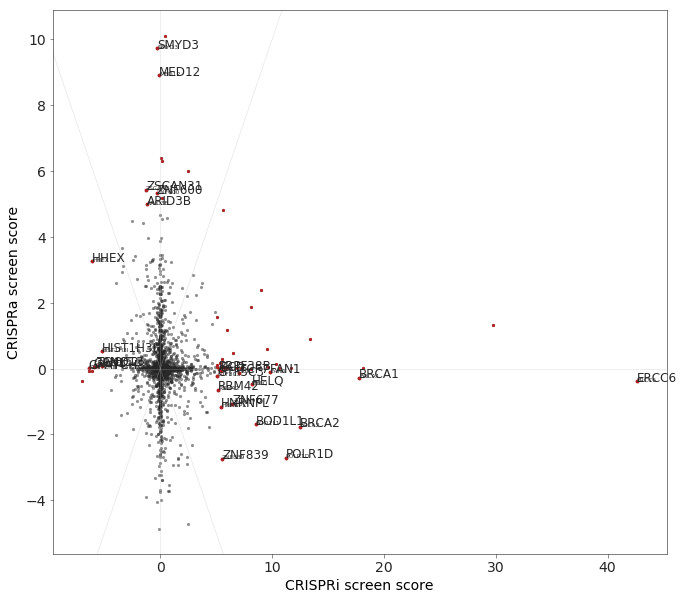

In [31]:
fig, ax = plt.subplots(1,1, figsize=(11, 10))
table = gene_table_a_rho["ave_Rep1_Rep2"].copy()
table["discScore_signed"] = [x["discScore"] if x["average phenotype of strongest 3"] < 0 else -x["discScore"] for i, x in table.iterrows()]
table_a = table.copy()
table = gene_table_i_rho["ave_Rep1_Rep2"].copy()
table["discScore_signed"] = [x["discScore"] if x["average phenotype of strongest 3"] < 0 else -x["discScore"] for i, x in table.iterrows()]
table_i = table.copy()
table_merged = table_i.merge(table_a, left_index=True, right_index=True)
table_merged["CRISPRa screen score"] = table_merged["discScore_signed_y"]
table_merged["CRISPRi screen score"] = table_merged["discScore_signed_x"]

ax.scatter(table_merged["discScore_signed_x"], table_merged["discScore_signed_y"], alpha=0.5, c = almost_black, lw = 0, s = 10, label='gene targeting sgRNAs', rasterized=True)
text = []
for i, row in table_merged.iterrows():
    if i in ["ERCC6", "ERCC4", "SETD1A", "BRCA1", "XPA", "BRCA2", "ELOF1", "POLR1D", "GTF2H5", "CPSF2", "FAN1", "ERCC8", "LEO1", "ZFP36L2", "BOD1L1", "HELQ", "ZKSCAN2", "TAF6L", "HMGN2", "TCF7", "RBM12", "ZNF691", "ZNF677", "DGCR14", "BRF2", "SRSF7", "GAR1", "POLR2B", "EGR3", "CWC22", "ZNF839", "HNRNPL", "SF3B5", "ECD", "FUBP1", "PRPF38B", "RBM42", "GTF3C3", "MCM9", "DKC1", "LARP7"]:
        ax.scatter(row["discScore_signed_x"], row["discScore_signed_y"], c = '#b22222', lw = 0, s = 10, rasterized=True)
    if i in ["SNRPA1", "GPATCH8", "SRSF6", "HHEX", "ESF1", "GPN1", "THOC2", "HIST1H3I", "CNOT3"]:
        ax.scatter(row["discScore_signed_x"], row["discScore_signed_y"], c = '#b22222', lw = 0, s = 10, rasterized=True)
    if i in ["RBM10", "SMYD3", "MED12", "TIGD2", "ARID5B", "ELP5", "ZSCAN31", "ZNF600", "ZNF148", "ARID3B"]:
        ax.scatter(row["discScore_signed_x"], row["discScore_signed_y"], c = '#b22222', lw = 0, s = 10, rasterized=True)
    if i in ["ZNF839", "POLR1D", "BRCA2", "BOD1L1", "HNRNPL", "ZNF677", "RBM42", "HELQ", "ERCC6", "BRCA1", "GTF3C3", "TCF7", "FAN1", "ECD", "PRPF38B"]:
        ax.scatter(row["discScore_signed_x"], row["discScore_signed_y"], c = '#b22222', lw = 0, s = 15, rasterized=True)
        text.append(plt.text(row["discScore_signed_x"], row["discScore_signed_y"], i, fontsize=6))
        ax.text(row["discScore_signed_x"], row["discScore_signed_y"], i, fontsize=12)
    if i in ["HHEX", "HIST1H3I", "THOC2", "CNOT3", "GPN1", "GPATCH8"]:
        ax.scatter(row["discScore_signed_x"], row["discScore_signed_y"], c = '#b22222', lw = 0, s = 15, rasterized=True)
        ax.text(row["discScore_signed_x"], row["discScore_signed_y"], i, fontsize=12)
        text.append(plt.text(row["discScore_signed_x"], row["discScore_signed_y"], i, fontsize=6))
    if i in ["SMYD3", "MED12", "ZSCAN31", "ZNF600", "ARID3B"]:
        ax.scatter(row["discScore_signed_x"], row["discScore_signed_y"], c = '#b22222', lw = 0, s = 15, rasterized=True)
        ax.text(row["discScore_signed_x"], row["discScore_signed_y"], i, fontsize=12)
        text.append(plt.text(row["discScore_signed_x"], row["discScore_signed_y"], i, fontsize=6))

ax.set_ylabel('CRISPRa screen score')
ax.set_xlabel('CRISPRi screen score')
plotGrid(ax)

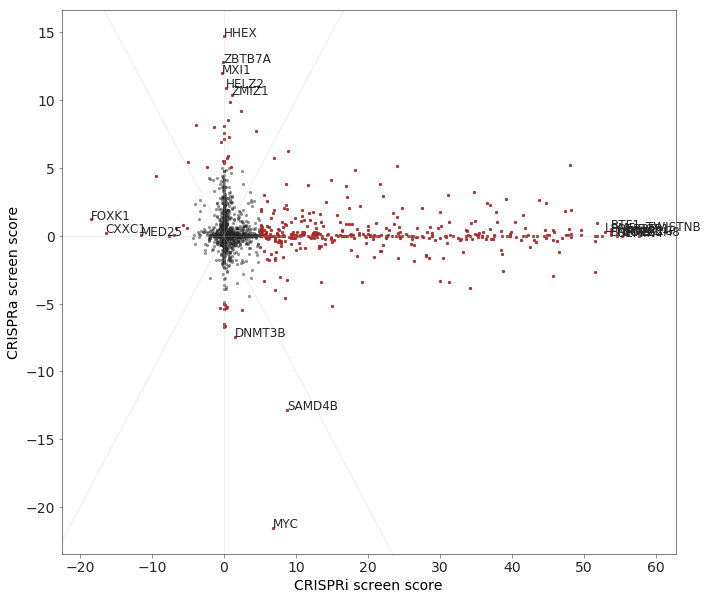

In [32]:
fig, ax = plt.subplots(1,1, figsize=(11, 10))
table = gene_table_a_gamma["ave_Rep1_Rep2"].copy()
table["discScore_signed"] = [x["discScore"] if x["average phenotype of strongest 3"] < 0 else -x["discScore"] for i, x in table.iterrows()]
table_a = table.copy()
table = gene_table_i_gamma["ave_Rep1_Rep2"].copy()
table["discScore_signed"] = [x["discScore"] if x["average phenotype of strongest 3"] < 0 else -x["discScore"] for i, x in table.iterrows()]
table_i = table.copy()
table_merged = table_i.merge(table_a, left_index=True, right_index=True)
table_merged["CRISPRa screen score"] = table_merged["discScore_signed_y"]
table_merged["CRISPRi screen score"] = table_merged["discScore_signed_x"]

ax.scatter(table_merged["discScore_signed_x"], table_merged["discScore_signed_y"], alpha=0.5, c = almost_black, lw = 0, s = 10, label='gene targeting sgRNAs', rasterized=True)
for i, row in table_merged.iterrows():
    if row["thres_x"] or row["thres_y"]:
        ax.scatter(row["discScore_signed_x"], row["discScore_signed_y"], c = '#b22222', lw = 0, s = 10, rasterized=True, alpha=0.8)
text = []
for i, row in table_merged.sort_values('discScore_signed_x').iloc[0:3].iterrows():
    text.append(plt.text(row["discScore_signed_x"], row["discScore_signed_y"], i, fontsize=12))
for i, row in table_merged.sort_values('discScore_signed_x', ascending=False).iloc[0:10].iterrows():
    text.append(plt.text(row["discScore_signed_x"], row["discScore_signed_y"], i, fontsize=12))
for i, row in table_merged.sort_values('discScore_signed_y').iloc[0:3].iterrows():
    text.append(plt.text(row["discScore_signed_x"], row["discScore_signed_y"], i, fontsize=12))
for i, row in table_merged.sort_values('discScore_signed_y', ascending=False).iloc[0:5].iterrows():
    text.append(plt.text(row["discScore_signed_x"], row["discScore_signed_y"], i, fontsize=12))
# adjust_text(text)
ax.set_ylabel('CRISPRa screen score')
ax.set_xlabel('CRISPRi screen score')
plotGrid(ax)
